In [1]:
using Gadfly
using Vec, LinearAlgebra
using GridWorldPathFollowing

In [72]:
start_pt = VecE2(0.0,0.0)
start_time = 0.0
action_sequence = [DOWN,RIGHT,WAIT,UP,RIGHT,WAIT,WAIT,RIGHT,RIGHT,DOWN,DOWN,LEFT,UP,LEFT,DOWN,LEFT,LEFT]
# action_sequence = [RIGHT,WAIT,UP,RIGHT]
cell_width = 1.0
transition_time = 2.0
grid_path = construct_grid_world_path(start_pt,start_time,
    action_sequence,cell_width,transition_time)

traj = construct_trajectory(grid_path)
verify(traj)

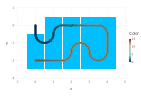

In [73]:
Δt = 0.01
t_range = get_start_time(traj):Δt:get_end_time(traj)
t_color_range = get_start_time(traj):(10*Δt):get_end_time(traj)
pad = 0.01
plot1 = plot(
    layer(
        x=[get_position(traj,t).x for t in t_range],
        y=[get_position(traj,t).y for t in t_range],
        Geom.path,
        Theme(default_color="black")
        ),
    layer(
        x=[get_position(traj,t).x for t in t_color_range],
        y=[get_position(traj,t).y for t in t_color_range],
        color=[get_dist(traj,t) for t in t_color_range],
        Geom.point
        ),
    layer(
        xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        Geom.rect
    ),
    Coord.cartesian(fixed=true)
)

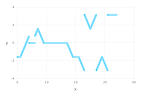

In [74]:
t_vec = collect(get_start_time(traj):0.1:get_end_time(traj))
plot(
    x=t_vec, 
    y=[atan(get_heading(traj,t)) for t in t_vec]
)

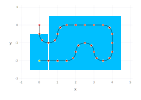

In [75]:
Δt = 0.01
t_range = get_start_time(traj):Δt:get_end_time(traj)
t_color_range = get_start_time(traj):(10*Δt):get_end_time(traj)
pad = 0.01
plot2 = plot(
    layer(
        x=[get_position(traj,t).x for t in t_range],
        y=[get_position(traj,t).y for t in t_range],
        Geom.path,
        Theme(default_color="black")
        ),
    layer(
        x=[get_start_pt(seg).x for seg in traj.segments],
        y=[get_start_pt(seg).y for seg in traj.segments],
        Geom.point,
        Theme(default_color="red")
        ),
    layer(
        x=[get_end_pt(seg).x for seg in traj.segments],
        y=[get_end_pt(seg).y for seg in traj.segments],
        Geom.point,
        Theme(default_color="yellow")
        ),
    layer(
        xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
        ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
        Geom.rect
    ),
    Coord.cartesian(fixed=true)
)

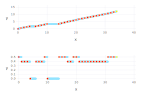

In [76]:
start_times = [get_start_time(seg) for seg in traj.segments]
final_times = [get_end_time(seg) for seg in traj.segments]
plot3 = plot(
    layer(x=start_times,y=[get_dist(traj,t) for t in start_times],Theme(default_color="red")),
    layer(x=final_times,y=[get_dist(traj,t) for t in final_times],Theme(default_color="yellow")),
    layer(x=collect(t_color_range),y=[get_dist(traj,t) for t in t_color_range])
)
plot4 = plot(
    layer(x=start_times,y=[norm(get_vel(traj,t)) for t in start_times],Theme(default_color="red")),
    layer(x=final_times,y=[norm(get_vel(traj,t)) for t in final_times],Theme(default_color="yellow")),
    layer(x=collect(t_color_range),y=[norm(get_vel(traj,t)) for t in t_color_range])
)
vstack(plot3,plot4)

# Optimize Velocity Profile
We apply a polynomial acceleration command in each time window

In [77]:
t_vec, accel, vel, pos = optimize_velocity_profile(traj);

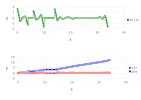

In [78]:
t = [[get_start_time(seg) for seg in traj.segments]..., get_end_time(traj)]
cum_d = cumsum([get_length(seg) for seg in traj.segments])
plot5 = vstack(
    plot(
        layer(x=t_vec[1:end-1],y=accel,Theme(default_color="green")),
        layer(x=t_vec[1:end-1],y=accel,Geom.step,Theme(default_color="green")),
        Guide.manual_color_key("",["accel"],["green"])
    ),
    plot(
        layer(x=t_vec,y=vel,Theme(default_color="red")),
        layer(x=t_vec,y=vel,Geom.step,Theme(default_color="red")),
        
        layer(x=t_vec,y=pos,Theme(default_color="blue")),
        layer(x=t_vec,y=pos,Geom.step,Theme(default_color="blue")),

        layer(x = t,y = [0, cum_d...],Geom.step,Theme(default_color="black")),
        Guide.manual_color_key("",["vel", "pos"],["red","blue"])
    )
)

# Closed-loop tracking of Trajectory with optimized speed profile

In [79]:
dense_traj = DenseTrajectory(traj,t_vec,accel,vel,pos);

In [18]:
using Parameters
@with_kw struct LookAheadController
    dt  ::Float64 = 0.0
    a   ::Float64 = 1.0
    k0  ::Float64 = 1.0 
    μ   ::Float64 = 1.0
    γ   ::Float64 = 0.1
    ϵ   ::Float64 = 0.1
    k1  ::Float64 = 1.0
    b   ::Float64 = 1.0
end

LookAheadController

In [83]:
sat(x,δ) = abs(x) <= δ ? x : sign(x)*δ
"""
    This function follows Lee et al., "Tracking Control of 
    Unicycle-Modeled Mobile Robots Using a Saturation Feedback Controller"


"""
function get_action(
        controller::LookAheadController,
        target::Vector{Float64},
        ff::Vector{Float64},
        state::Vector{Float64})
    a = controller.a   # 0 < a < vmax - sup_{t >= 0} abs(vr)
    k0 = controller.k0 # k0 > 0
    μ = controller.μ   # μ = 0 or 1
    γ = controller.γ   # 0 < γ < 1
    ϵ = controller.ϵ   # 0 < ϵ < 1/(1+γ)
    k1 = controller.k1 # k1 > 0
    b = controller.b   # b > 0
    # state (global frame)
    x = state[1] 
    y = state[2] 
    θ = state[3] 
    # reference (global frame)
    xr = target[1] 
    yr = target[2] 
    θr = target[3] 
    vr = ff[1]
    wr = ff[2]
    # errors in robot frame
    e = [ cos(θ) sin(θ) 0;
         -sin(θ) cos(θ) 0;
              0      0  1]*[xr-x,yr-y,get_angular_offset(θ,θr)]
    xe = e[1]
    ye = e[2]
    θe = e[3]
    # change of coordinates
    x0 = θe
    x1 = ye
    x2 = -xe
    # u0 = wr - w
    # u1 = v - vr*cos(x0)
    V1 = x1^2 + x2^2
    u1 = -sat(k0*x2,a)
    h = 1 + γ*cos(μ*t)
    h_dot = -μ*γ*sin(μ*t)
    x0_ = x0 + ϵ*h*x1 / (1 + V1^(1/2))
    α = 1 - ϵ*h*x2 / (1 + V1^(1/2))
    β = ϵ*( 
        (h_dot*x1+h*wr*x2+h*vr*sin(x0))/(1 + V1^(1/2)) 
        - (h*x1/( ((1 + V1^(1/2))^2)*V1^(1/2) ))
        * (x1*vr*sin(x0) - sat(k0*x2,a)*x2)
    )
    u0 = -β/α - sat(k1*x0_,b)
    # transform back
    w = -u0 + wr
    v = u1 + vr*cos(x0)
    return [w, v]
end

get_action (generic function with 1 method)

In [20]:
function dynamics(state,cmd)
    x = state[1]
    y = state[2]
    θ = state[3]
    w = cmd[1]
    v = cmd[2]
    sdot = [v*cos(θ),v*sin(θ),w]
end
function get_next_state(state::Vector{Float64},u::Vector{Float64},dt::Float64;nsteps=10)
    s = deepcopy(state)
    for i in 1:nsteps
        sdot = dynamics(s,u)
        s += sdot*dt/nsteps
    end
    return s
end

get_next_state (generic function with 1 method)

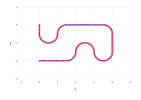

In [86]:
controller = LookAheadController(μ=0.01)
dt = 0.1
t = 0.0
state_pt = get_trajectory_point_by_time(traj, t)
state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] - 0.01*rand(3)
states = Vector{Vector{Float64}}([state])
errors = Vector{Float64}()
t_vec = collect(t:dt:get_end_time(dense_traj))
while t < get_end_time(traj)
    # get target state in global frame
    target_pt = get_trajectory_point_by_time(traj, t)
    target = [target_pt.pos.x, target_pt.pos.y, atan(target_pt.heading)]
    push!(errors, norm(target[1:2] - state[1:2]))
    ff = [norm(target_pt.vel), target_pt.yaw_rate]
    if abs(ff[1]) >= 0.000001 # dirty trick to avoid problems with waiting
        u = get_action(controller,target,ff,state)
        state = get_next_state(state,u,dt)
    end
    push!(states, state)
    t += dt
end
plot(
    layer(
        x=[s[1] for s in states],
        y=[s[2] for s in states],
        Geom.path,Theme(default_color="blue")),
    layer(
        x=[get_position(dense_traj,t).x for t in t_vec],
        y=[get_position(dense_traj,t).y for t in t_vec],
        Theme(default_color="red")
        ),
    Coord.Cartesian(fixed=true)
)

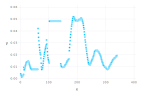

In [87]:
plot(
    x = collect(1:length(errors)),
    y = errors
)